# Trabajo practico N° 4
#### Alumno: Bucca Matias
## Python Fixed Point
El objetivo es aplicar los conceptos de Aritmética de Punto Fijo usando la clase de Python
fixedInt.py.
##  Ejercicio 1
Aplicar los conceptos de aritmética de punto fijo sobre el filtro rcosine del simulador realizado
en python en el archivo tx rcosine procom.py
### Actividad 1
Generar tres filtros con rolloff [0.0,0.5,1.0] en punto flotante con NBaud = 16, F Baud =
1G y OS = 8.

In [58]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *
## Parametros generales
T     = 1.0/10.0e9    # Periodo de baudio
Nsymb = 1000          # Numero de simbolos
os    = 8             # Over sampling
## Parametros de la respuesta en frecuencia
Nfreqs = 256          # Cantidad de frecuencias

## Parametros del filtro de caida cosenoidal
beta   = [0.0,0.5,1.0] # Roll-Off
Nbauds = 16.0          # Cantidad de baudios del filtro
## Parametros funcionales
Ts = T/os              # Frecuencia de muestreo

Funcion para generar el filtro.

In [59]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud,float(Tbaud)/oversampling)
    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/(1-(4.0*beta*beta*t*t/(Tbaud*Tbaud)))))
    y_vect = np.array(y_vect)
    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
    else:
        return (t_vect,y_vect)

Calculo de tres filtros RC con diferente roll-off.

In [60]:
(t,rc0) = rcosine(beta[0], T,os,Nbauds,Norm=False)
(t,rc1) = rcosine(beta[1], T,os,Nbauds,Norm=False)
(t,rc2) = rcosine(beta[2], T,os,Nbauds,Norm=False)

### Actividad 2
Graficar la respuesta al impulso y frecuencia.

Respuesta al impulso.

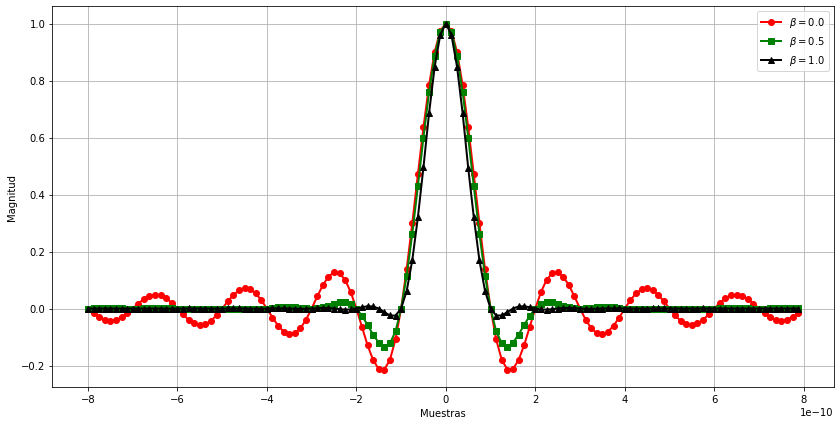

In [63]:
plt.figure(figsize=[14,7])
plt.plot(t,rc0,'ro-',linewidth=2.0,label=r'$\beta=0.0$')
plt.plot(t,rc1,'gs-',linewidth=2.0,label=r'$\beta=0.5$')
plt.plot(t,rc2,'k^-',linewidth=2.0,label=r'$\beta=1.0$')
plt.legend()
plt.grid(True)
#plt.xlim(0,len(rc0)-1)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.show()

Calculo de respuesta en frecuencia.

In [64]:
def resp_freq(filt, Ts, Nfreqs):
    #Computo de la respuesta en frecuencia de cualquier filtro FIR
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

Grafico de la respuesta en frecuencia.

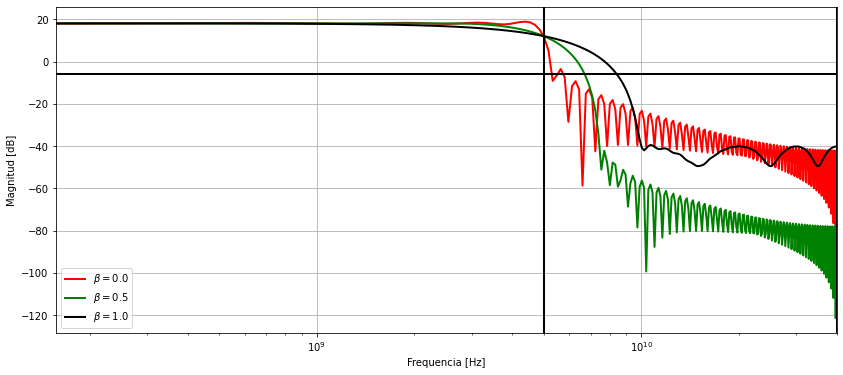

In [65]:
### Calculo respuesta en frec para los tres pulsos
[H0,A0,F0] = resp_freq(rc0, Ts, Nfreqs)
[H1,A1,F1] = resp_freq(rc1, Ts, Nfreqs)
[H2,A2,F2] = resp_freq(rc2, Ts, Nfreqs)

### Generacion de los graficos
plt.figure(figsize=[14,6])
plt.semilogx(F0, 20*np.log10(H0),'r', linewidth=2.0, label=r'$\beta=0.0$')
plt.semilogx(F1, 20*np.log10(H1),'g', linewidth=2.0, label=r'$\beta=0.5$')
plt.semilogx(F2, 20*np.log10(H2),'k', linewidth=2.0, label=r'$\beta=1.0$')

plt.axvline(x=(1./Ts)/2.,color='k',linewidth=2.0)
plt.axvline(x=(1./T)/2.,color='k',linewidth=2.0)
plt.axhline(y=20*np.log10(0.5),color='k',linewidth=2.0)
plt.legend(loc=3)
plt.grid(True)
plt.xlim(F2[1],F2[len(F2)-1])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

### Actividad 3
Graficar la convolución de los tres filtros con los símbolos a transmitir y la constelación
buscado la fase óptima.

Grafico para rolloff 0.0

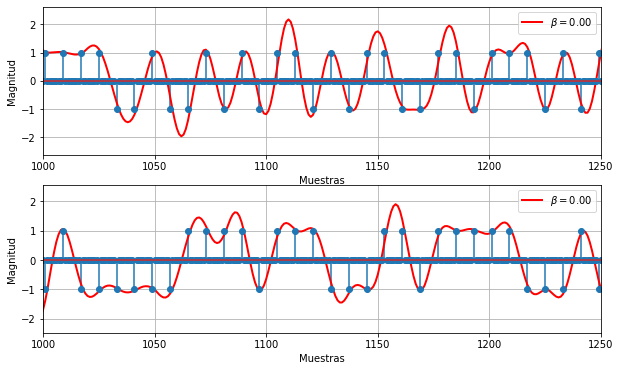

In [66]:
symbolsI = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;
symbolsQ = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;
zsymbI = np.zeros(os*Nsymb); zsymbI[1:len(zsymbI):int(os)]=symbolsI
zsymbQ = np.zeros(os*Nsymb); zsymbQ[1:len(zsymbQ):int(os)]=symbolsQ

symb_out0I = np.convolve(rc0,zsymbI,'same'); 
symb_out0Q = np.convolve(rc0,zsymbQ,'same')
plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(symb_out0I,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[0])
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(symb_out0Q,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[0])
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Grafico para rolloff 0.5

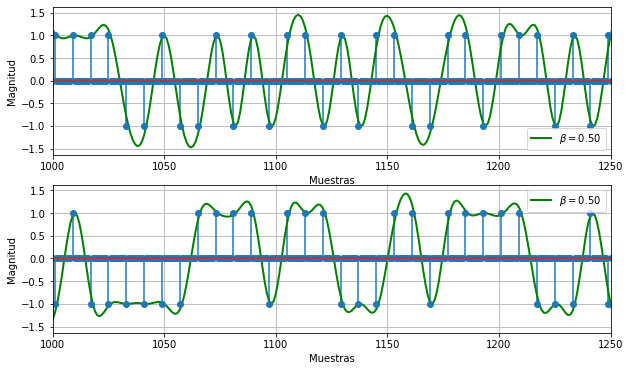

In [67]:
symb_out1I = np.convolve(rc1,zsymbI,'same'); symb_out1Q = np.convolve(rc1,zsymbQ,'same')

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(symb_out1I,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[1])
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(symb_out1Q,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[1])
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Grafico para rolloff 1.0

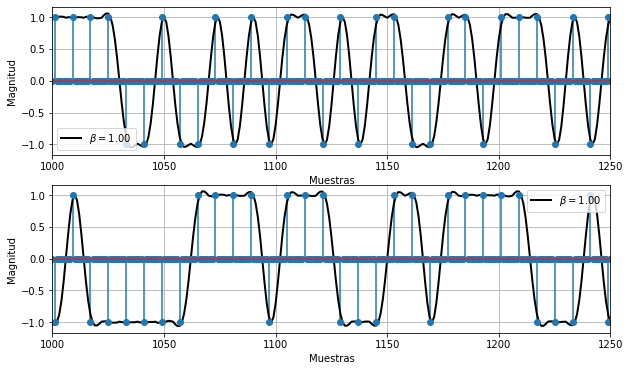

In [68]:
symb_out2I = np.convolve(rc2,zsymbI,'same')
symb_out2Q = np.convolve(rc2,zsymbQ,'same')

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(symb_out2I,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[2])
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(symb_out2Q,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta[2])
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

#### Busqueda de fase optima

Constellación con offset 2.

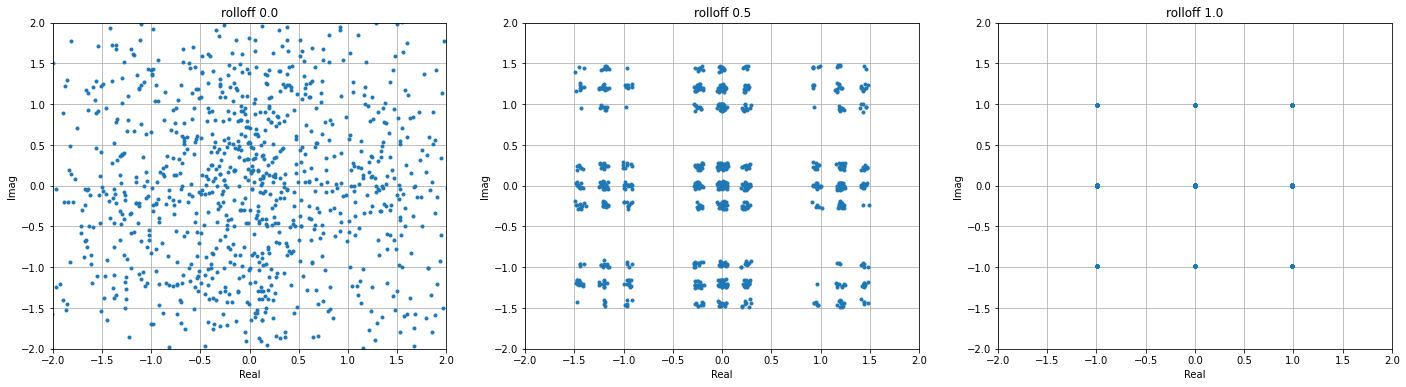

In [69]:
offset = 2

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0")

plt.subplot(1,3,2)
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")

plt.subplot(1,3,3)
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0")

plt.show()

Constellación con offset 3.

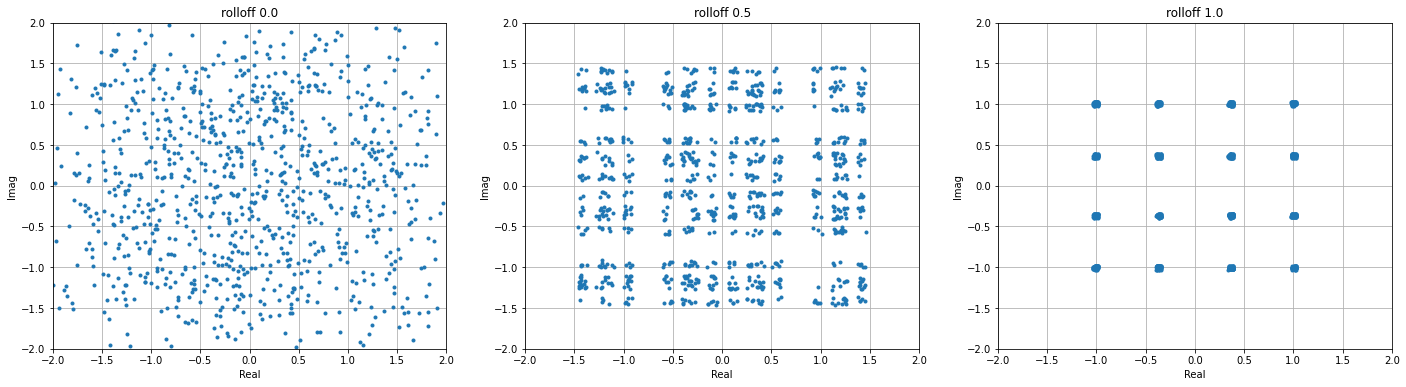

In [70]:
offset = 3

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0")

plt.subplot(1,3,2)
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")

plt.subplot(1,3,3)
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0")

plt.show()

Constellación con offset 4.

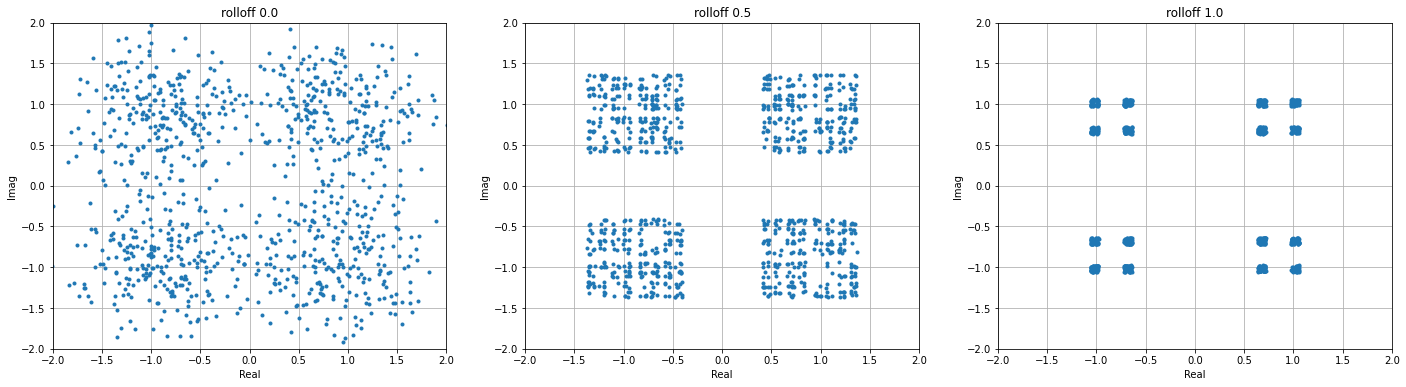

In [71]:
offset = 4

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0")

plt.subplot(1,3,2)
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")

plt.subplot(1,3,3)
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0")

plt.show()

Constellación con offset 5.

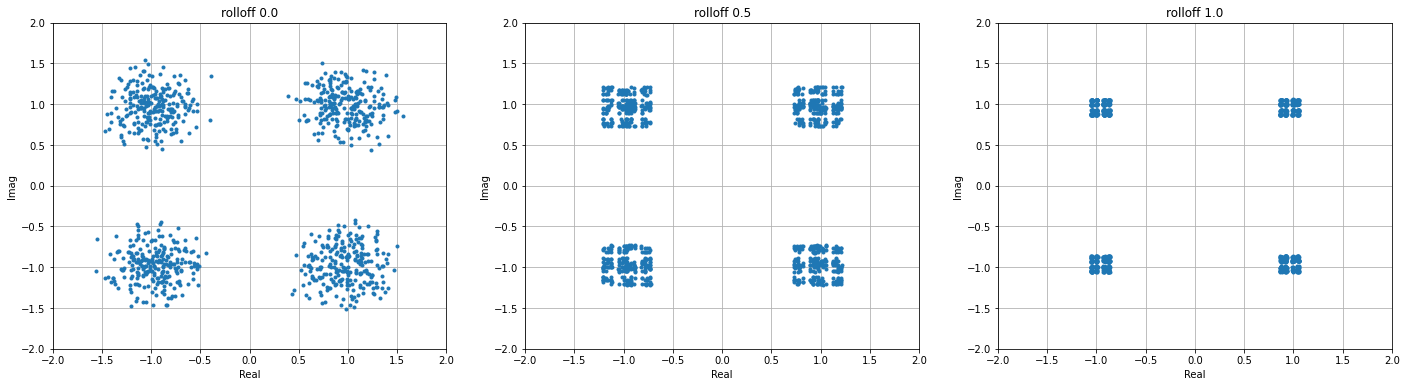

In [72]:
offset = 5

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0")

plt.subplot(1,3,2)
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")

plt.subplot(1,3,3)
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0")

plt.show()

Constellación con offset 6.

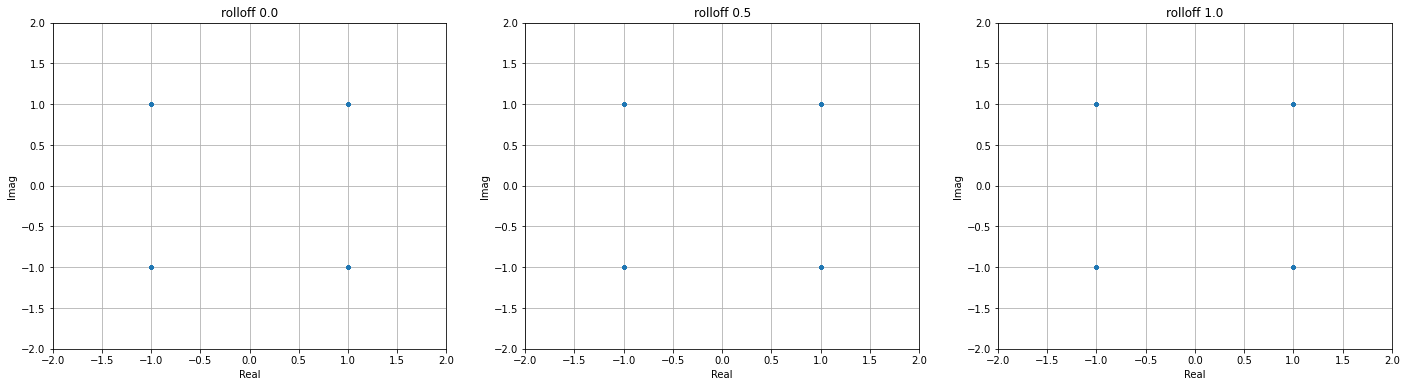

In [73]:
offset = 6

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0")

plt.subplot(1,3,2)
plt.plot(symb_out1I[100+offset:len(symb_out1I)-(100-offset):int(os)],
         symb_out1Q[100+offset:len(symb_out1Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")

plt.subplot(1,3,3)
plt.plot(symb_out2I[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0")

plt.show()

Como se puede ver en los graficos, la fase optima se consigue con un valor de 6.

### Actividad 4, 5 y 6
Sobre cada filtro aplicar las siguiente cuantizaciones: S(8, 7) truncado, S(8, 7) redondeo,
S(3, 2) truncado, S(3, 2) redondeo, S(6, 4) truncado y S(6, 4) redondeo. En todos los
casos considerar saturación.

#### Cuantización S(8,7).

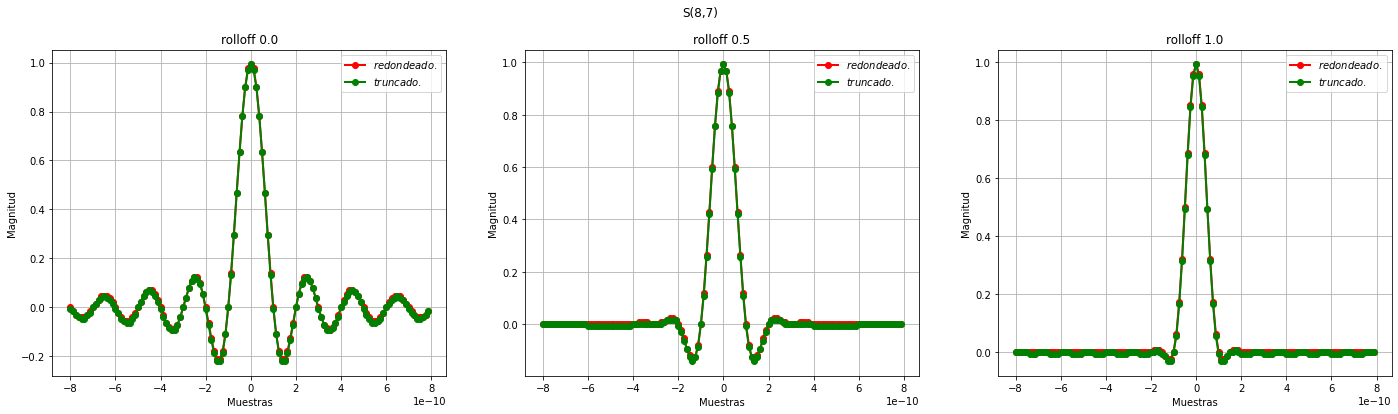

In [74]:
#_______________________ rolloff  0.0 ___________________
rc0_aux=arrayFixedInt(8, 7,rc0 , signedMode='S', roundMode='round', saturateMode='saturate')
rc0_sxx_r=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
rc0_aux=arrayFixedInt(8, 7,rc0 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc0_sxx_t=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  0.5 ___________________
rc1_aux=arrayFixedInt(8, 7,rc1 , signedMode='S', roundMode='round', saturateMode='saturate')
rc1_sxx_r=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
rc1_aux=arrayFixedInt(8, 7,rc1 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc1_sxx_t=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  1.0 ___________________
rc2_aux=arrayFixedInt(8, 7,rc2 , signedMode='S', roundMode='round', saturateMode='saturate')
rc2_sxx_r=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])
rc2_aux=arrayFixedInt(8, 7,rc2 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc2_sxx_t=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(t,rc0_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc0_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.0")


plt.subplot(1,3,2)
plt.plot(t,rc1_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc1_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.5")


plt.subplot(1,3,3)
plt.plot(t,rc2_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc2_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 1.0")
plt.suptitle('S(8,7)') 
plt.show()

Respuesta en frecuencia.

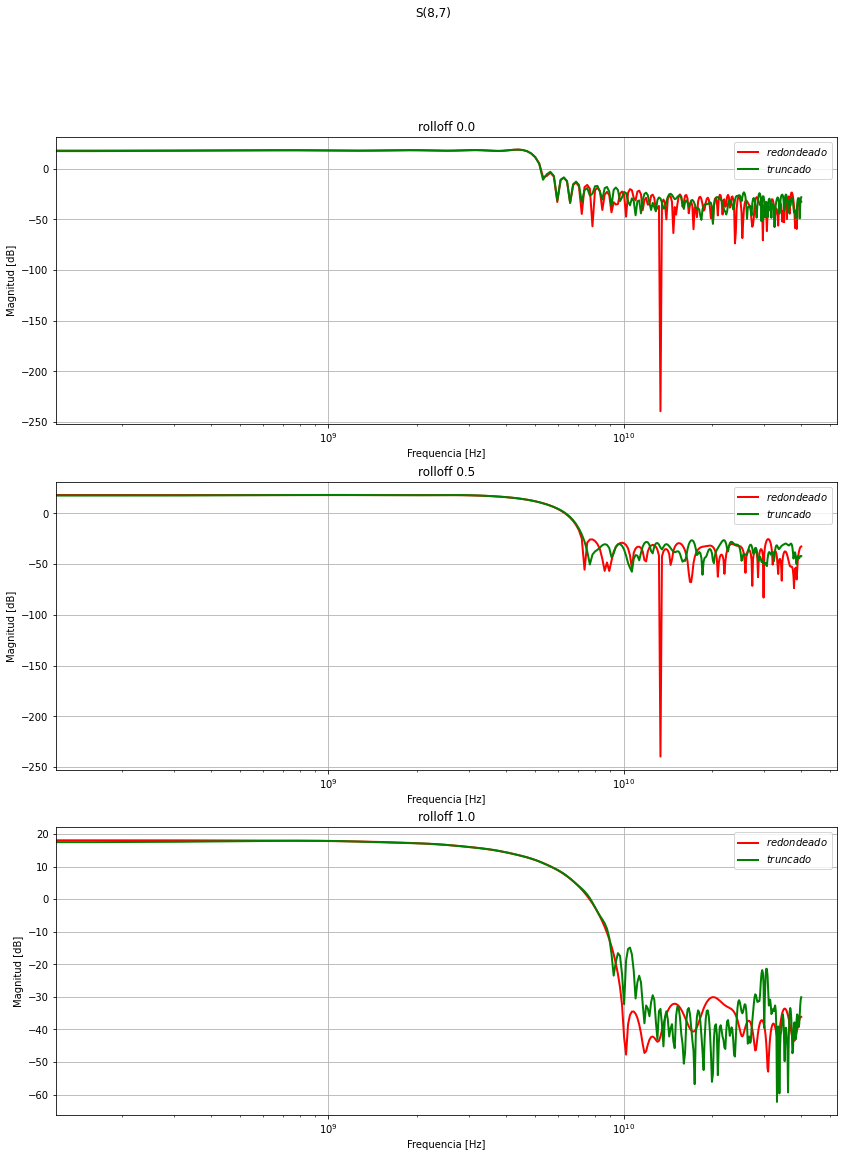

In [75]:
#_______________________ rolloff  0.0 ___________________
[H0_r,A0_r,F0_r] = resp_freq(rc0_sxx_r, Ts, Nfreqs)
[H0_t,A0_t,F0_t] = resp_freq(rc0_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.5 ___________________
[H1_r,A1_r,F1_r] = resp_freq(rc1_sxx_r, Ts, Nfreqs)
[H1_t,A1_t,F1_t] = resp_freq(rc1_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  1.0 ___________________
[H2_r,A2_r,F2_r] = resp_freq(rc2_sxx_r, Ts, Nfreqs)
[H2_t,A2_t,F2_t] = resp_freq(rc2_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.0 ___________________
plt.figure(figsize=[14,6*3])
plt.subplot(3,1,1)
plt.semilogx(F0_r, 20*np.log10(H0_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F0_t, 20*np.log10(H0_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.0')
#_______________________ rolloff  0.5 ___________________
plt.subplot(3,1,2)
plt.semilogx(F1_r, 20*np.log10(H1_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F1_t, 20*np.log10(H1_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.5')
#_______________________ rolloff  1.0 ___________________
plt.subplot(3,1,3)
plt.semilogx(F2_r, 20*np.log10(H2_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F2_t, 20*np.log10(H2_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 1.0')
plt.suptitle('S(8,7)') 
plt.show()

Convolución.

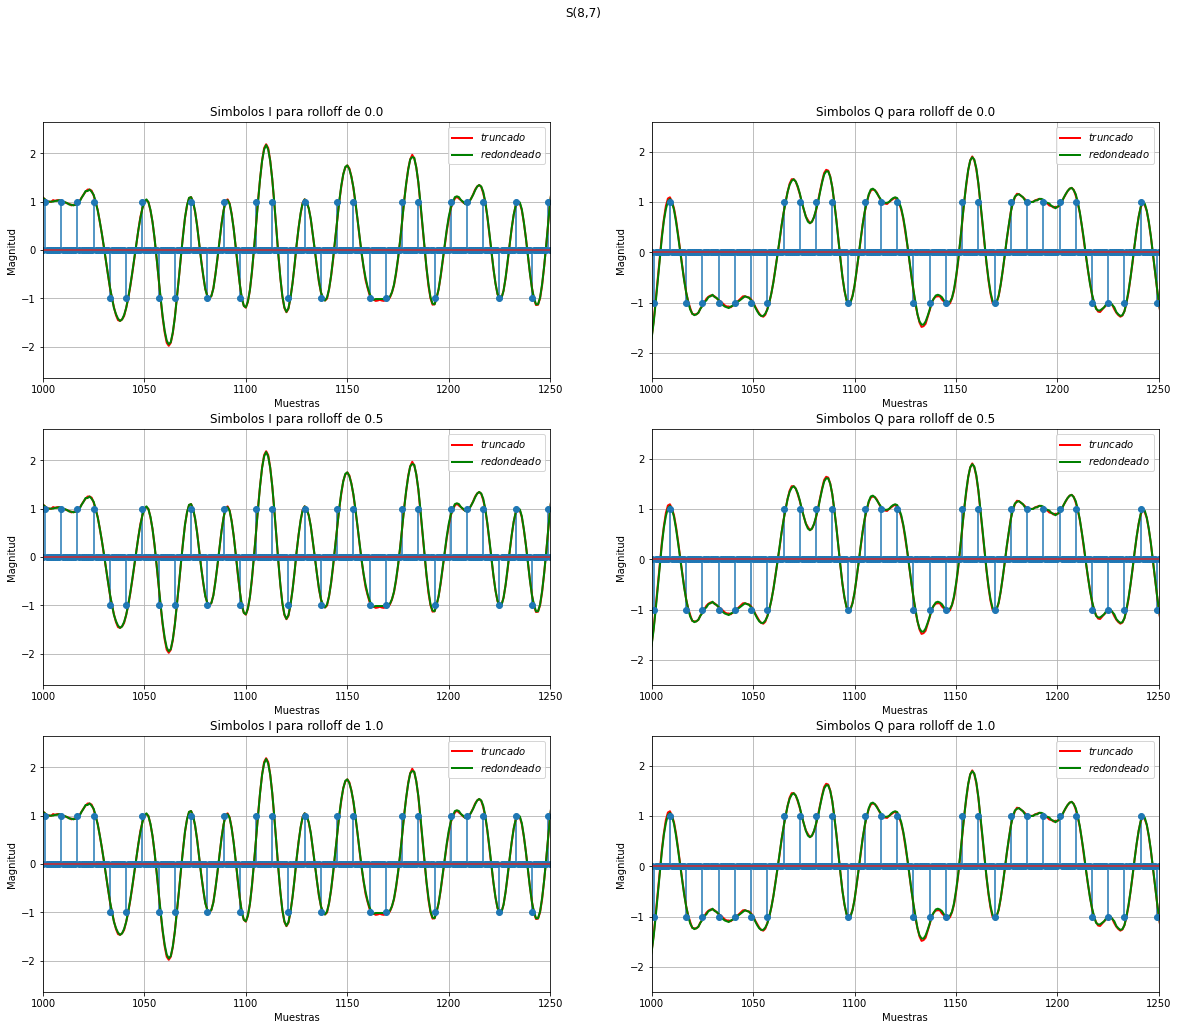

In [76]:
#_______________________ rolloff  0.0 ___________________
symb_out0I_r = np.convolve(rc0_sxx_r,zsymbI,'same')
symb_out0Q_r = np.convolve(rc0_sxx_r,zsymbQ,'same')
symb_out0I_t = np.convolve(rc0_sxx_t,zsymbI,'same')
symb_out0Q_t = np.convolve(rc0_sxx_t,zsymbQ,'same')
#_______________________ rolloff  0.5 ___________________
symb_out1I_r = np.convolve(rc1_sxx_r,zsymbI,'same')
symb_out1Q_r = np.convolve(rc1_sxx_r,zsymbQ,'same')
symb_out1I_t = np.convolve(rc1_sxx_t,zsymbI,'same')
symb_out1Q_t = np.convolve(rc1_sxx_t,zsymbQ,'same')
#_______________________ rolloff  1.0 ___________________
symb_out2I_r = np.convolve(rc2_sxx_r,zsymbI,'same')
symb_out2Q_r = np.convolve(rc2_sxx_r,zsymbQ,'same')
symb_out2I_t = np.convolve(rc2_sxx_t,zsymbI,'same')
symb_out2Q_t = np.convolve(rc2_sxx_t,zsymbQ,'same')

plt.figure(figsize=[10*2,4*4])
plt.subplot(3,2,1)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.0')
plt.subplot(3,2,2)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.0')


plt.subplot(3,2,3)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.5')
plt.subplot(3,2,4)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.5')


plt.subplot(3,2,5)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 1.0')
plt.subplot(3,2,6)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 1.0')
plt.suptitle('S(8,7)') 

plt.show()

Constelación.

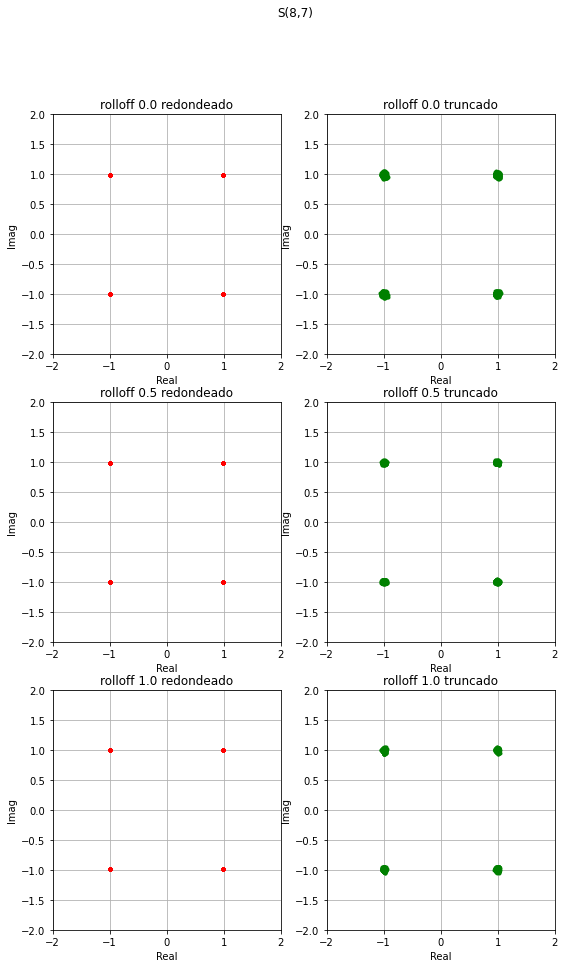

In [77]:
offset = 6

plt.figure(figsize=[3*3,3*5])
plt.subplot(3,2,1)
plt.plot(symb_out0I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 redondeado")
plt.subplot(3,2,2)
plt.plot(symb_out0I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 truncado")

#_______________________ rolloff  0.5 ___________________
plt.subplot(3,2,3)
plt.plot(symb_out1I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 redondeado")
plt.subplot(3,2,4)
plt.plot(symb_out1I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 truncado")

#_______________________ rolloff  1.0 ___________________
plt.subplot(3,2,5)
plt.plot(symb_out2I_r[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q_r[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 redondeado")
plt.subplot(3,2,6)
plt.plot(symb_out2I_t[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q_t[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 truncado")
plt.suptitle('S(8,7)') 
plt.show()

SNR:

In [78]:
#_______________________ rolloff  0.0 ___________________
pow_rc0_I=np.sum(symb_out0I**2)/len(symb_out0I)
pow_rc0_Q=np.sum(symb_out0Q**2)/len(symb_out0Q)

pow_rc0_I_r=np.sum(symb_out0I_r**2)/len(symb_out0I_r)
pow_rc0_Q_r=np.sum(symb_out0Q_r**2)/len(symb_out0Q_r)

pow_rc0_I_t=np.sum(symb_out0I_t**2)/len(symb_out0I_t)
pow_rc0_Q_t=np.sum(symb_out0Q_t**2)/len(symb_out0Q_t)

snr_rc0_I_r=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_r))
snr_rc0_Q_r=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_r))

snr_rc0_I_t=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_t))
snr_rc0_Q_t=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_t))
#_______________________ rolloff  0.5 ___________________
pow_rc1_I=np.sum(symb_out1I**2)/len(symb_out1I)
pow_rc1_Q=np.sum(symb_out1Q**2)/len(symb_out1Q)
pow_rc1_I_r=np.sum(symb_out1I_r**2)/len(symb_out1I_r)
pow_rc1_Q_r=np.sum(symb_out1Q_r**2)/len(symb_out1Q_r)
pow_rc1_I_t=np.sum(symb_out1I_t**2)/len(symb_out1I_t)
pow_rc1_Q_t=np.sum(symb_out1Q_t**2)/len(symb_out1Q_t)

snr_rc1_I_r=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_r))
snr_rc1_Q_r=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_r))

snr_rc1_I_t=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_t))
snr_rc1_Q_t=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_t))
#_______________________ rolloff  1.0 ___________________
pow_rc2_I=np.sum(symb_out2I**2)/len(symb_out2I)
pow_rc2_Q=np.sum(symb_out2Q**2)/len(symb_out2Q)
pow_rc2_I_r=np.sum(symb_out2I_r**2)/len(symb_out2I_r)
pow_rc2_Q_r=np.sum(symb_out2Q_r**2)/len(symb_out2Q_r)
pow_rc2_I_t=np.sum(symb_out2I_t**2)/len(symb_out2I_t)
pow_rc2_Q_t=np.sum(symb_out2Q_t**2)/len(symb_out2Q_t)

snr_rc2_I_r=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_r))
snr_rc2_Q_r=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_r))

snr_rc2_I_t=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_t))
snr_rc2_Q_t=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_t))

print("rolloff 0.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc0_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc0_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_t))+' dB')
print("rolloff 0.5 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc1_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc1_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_t))+' dB')
print("rolloff 1.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc2_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc2_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_t))+' dB')

rolloff 0.0 
  redondeo SNR_I: 50.59403926616386 dB  SNR_Q: 50.35197540193866 dB
  truncado SNR_I: 54.812826101409115 dB  SNR_Q: 50.119432797428104 dB
rolloff 0.5 
  redondeo SNR_I: 63.30346370396611 dB  SNR_Q: 67.21192440203706 dB
  truncado SNR_I: 51.04639180392898 dB  SNR_Q: 46.52134621120369 dB
rolloff 1.0 
  redondeo SNR_I: 72.7071848411111 dB  SNR_Q: 70.08606905674203 dB
  truncado SNR_I: 43.90640233665928 dB  SNR_Q: 41.08254660321269 dB


#### Cuantización S(3,2).

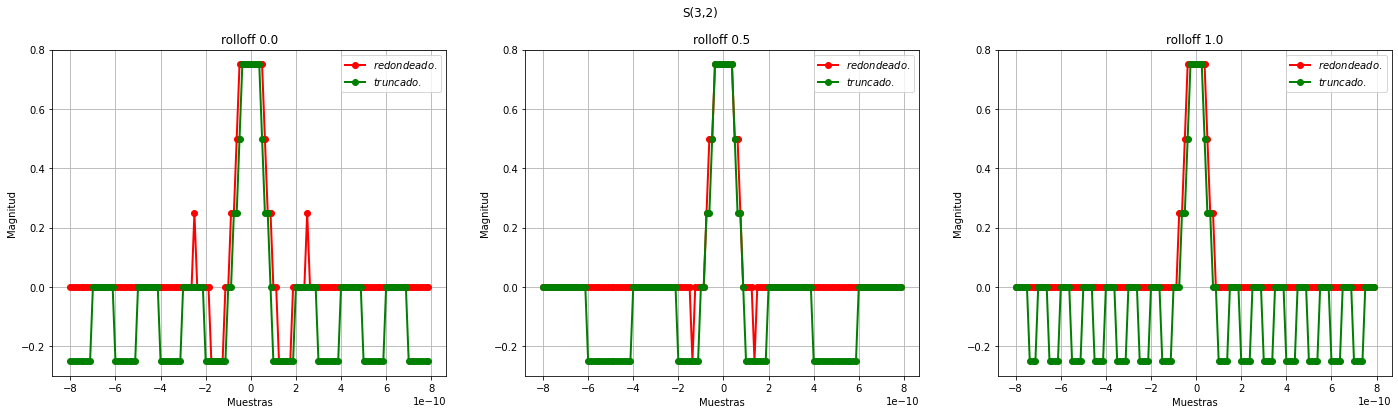

In [79]:
#_______________________ rolloff  0.0 ___________________
rc0_aux=arrayFixedInt(3, 2,rc0 , signedMode='S', roundMode='round', saturateMode='saturate')
rc0_sxx_r=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
rc0_aux=arrayFixedInt(3, 2,rc0 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc0_sxx_t=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  0.5 ___________________
rc1_aux=arrayFixedInt(3, 2,rc1 , signedMode='S', roundMode='round', saturateMode='saturate')
rc1_sxx_r=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
rc1_aux=arrayFixedInt(3, 2,rc1 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc1_sxx_t=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  1.0 ___________________
rc2_aux=arrayFixedInt(3, 2,rc2 , signedMode='S', roundMode='round', saturateMode='saturate')
rc2_sxx_r=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])
rc2_aux=arrayFixedInt(3, 2,rc2 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc2_sxx_t=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(t,rc0_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc0_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.0")


plt.subplot(1,3,2)
plt.plot(t,rc1_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc1_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.5")


plt.subplot(1,3,3)
plt.plot(t,rc2_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc2_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 1.0")
plt.suptitle('S(3,2)') 
plt.show()

Respuesta en frecuencia.

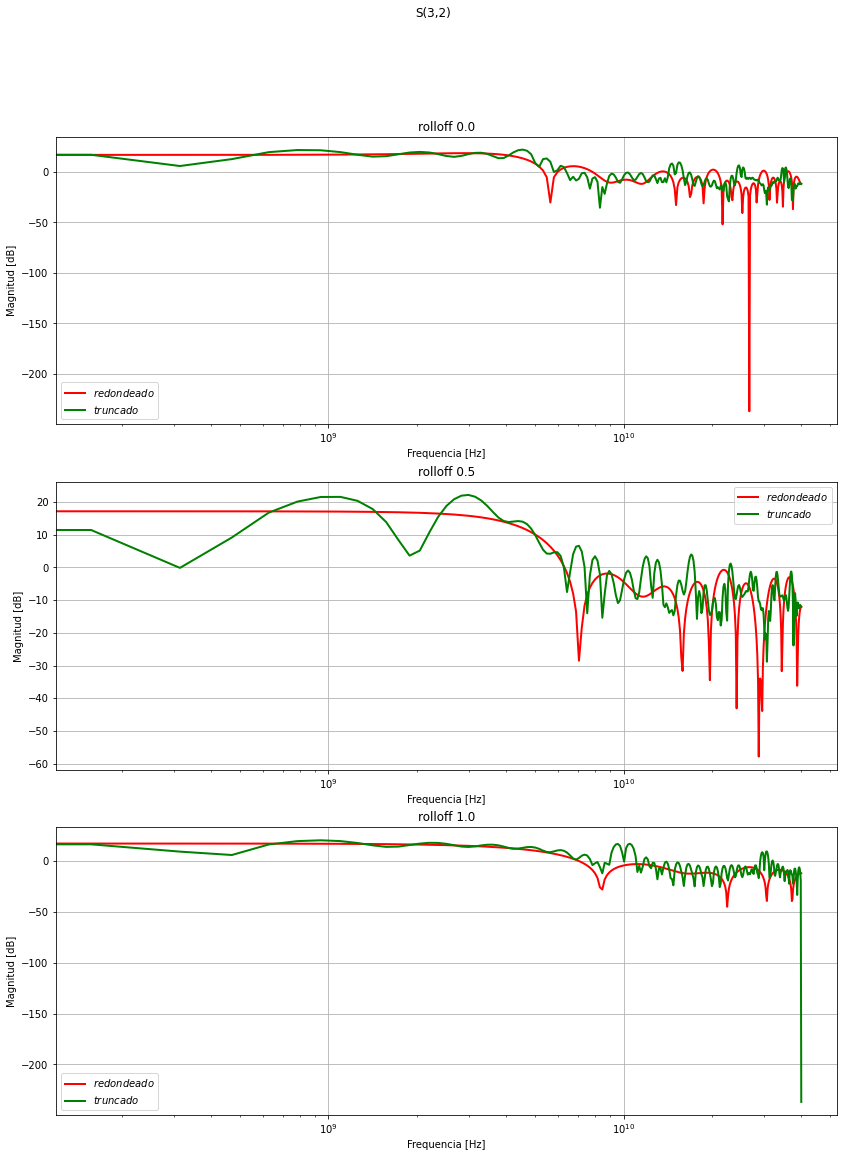

In [80]:
#_______________________ rolloff  0.0 ___________________
[H0_r,A0_r,F0_r] = resp_freq(rc0_sxx_r, Ts, Nfreqs)
[H0_t,A0_t,F0_t] = resp_freq(rc0_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.5 ___________________
[H1_r,A1_r,F1_r] = resp_freq(rc1_sxx_r, Ts, Nfreqs)
[H1_t,A1_t,F1_t] = resp_freq(rc1_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  1.0 ___________________
[H2_r,A2_r,F2_r] = resp_freq(rc2_sxx_r, Ts, Nfreqs)
[H2_t,A2_t,F2_t] = resp_freq(rc2_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.0 ___________________
plt.figure(figsize=[14,6*3])
plt.subplot(3,1,1)
plt.semilogx(F0_r, 20*np.log10(H0_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F0_t, 20*np.log10(H0_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.0')
#_______________________ rolloff  0.5 ___________________
plt.subplot(3,1,2)
plt.semilogx(F1_r, 20*np.log10(H1_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F1_t, 20*np.log10(H1_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.5')
#_______________________ rolloff  1.0 ___________________
plt.subplot(3,1,3)
plt.semilogx(F2_r, 20*np.log10(H2_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F2_t, 20*np.log10(H2_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 1.0')
plt.suptitle('S(3,2)') 
plt.show()

Convolución.

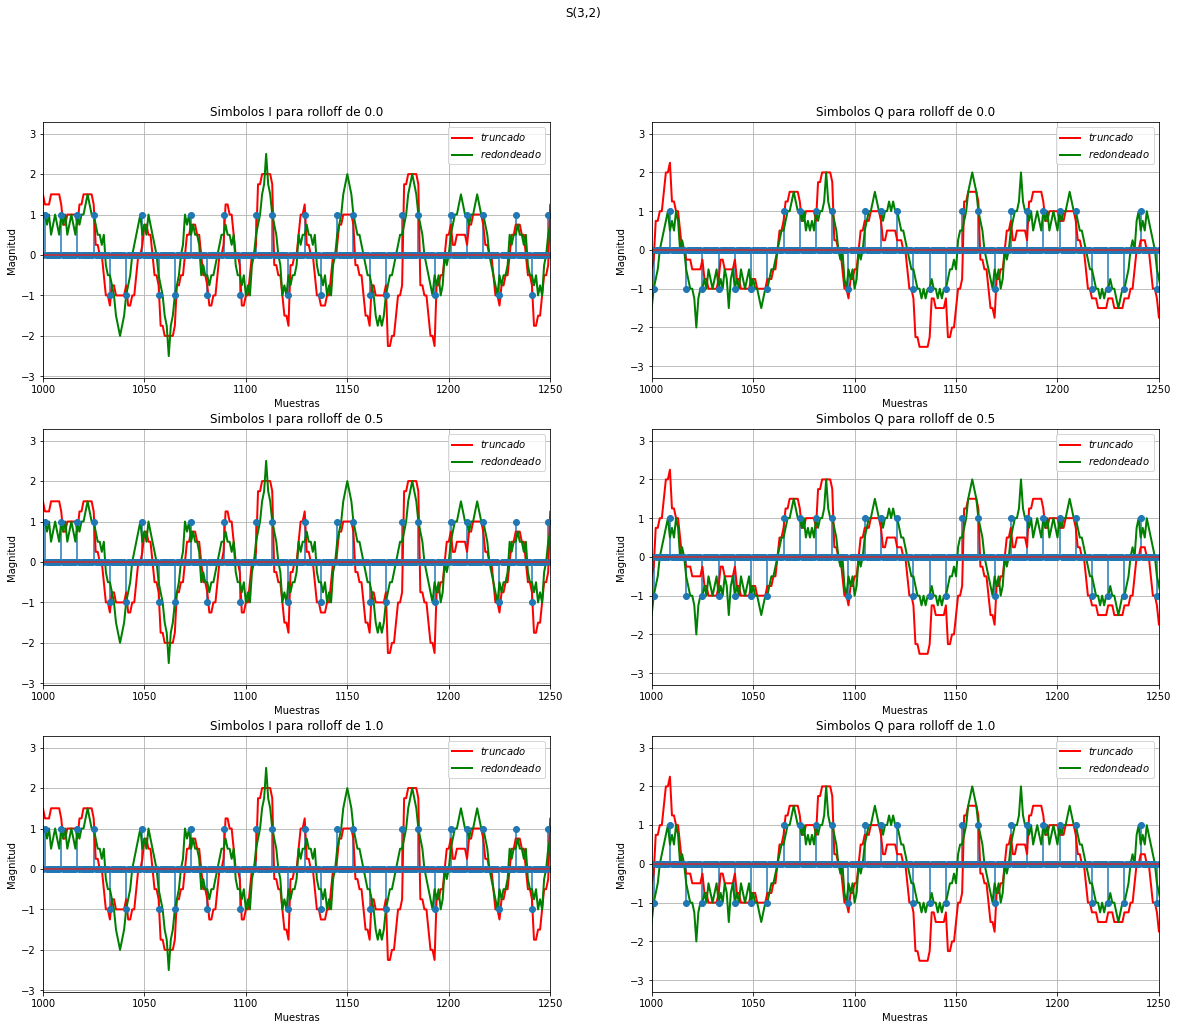

In [81]:
#_______________________ rolloff  0.0 ___________________
symb_out0I_r = np.convolve(rc0_sxx_r,zsymbI,'same')
symb_out0Q_r = np.convolve(rc0_sxx_r,zsymbQ,'same')
symb_out0I_t = np.convolve(rc0_sxx_t,zsymbI,'same')
symb_out0Q_t = np.convolve(rc0_sxx_t,zsymbQ,'same')
#_______________________ rolloff  0.5 ___________________
symb_out1I_r = np.convolve(rc1_sxx_r,zsymbI,'same')
symb_out1Q_r = np.convolve(rc1_sxx_r,zsymbQ,'same')
symb_out1I_t = np.convolve(rc1_sxx_t,zsymbI,'same')
symb_out1Q_t = np.convolve(rc1_sxx_t,zsymbQ,'same')
#_______________________ rolloff  1.0 ___________________
symb_out2I_r = np.convolve(rc2_sxx_r,zsymbI,'same')
symb_out2Q_r = np.convolve(rc2_sxx_r,zsymbQ,'same')
symb_out2I_t = np.convolve(rc2_sxx_t,zsymbI,'same')
symb_out2Q_t = np.convolve(rc2_sxx_t,zsymbQ,'same')

plt.figure(figsize=[10*2,4*4])
plt.subplot(3,2,1)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.0')
plt.subplot(3,2,2)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.0')


plt.subplot(3,2,3)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.5')
plt.subplot(3,2,4)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.5')


plt.subplot(3,2,5)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 1.0')
plt.subplot(3,2,6)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 1.0')
plt.suptitle('S(3,2)') 

plt.show()

Constelación.

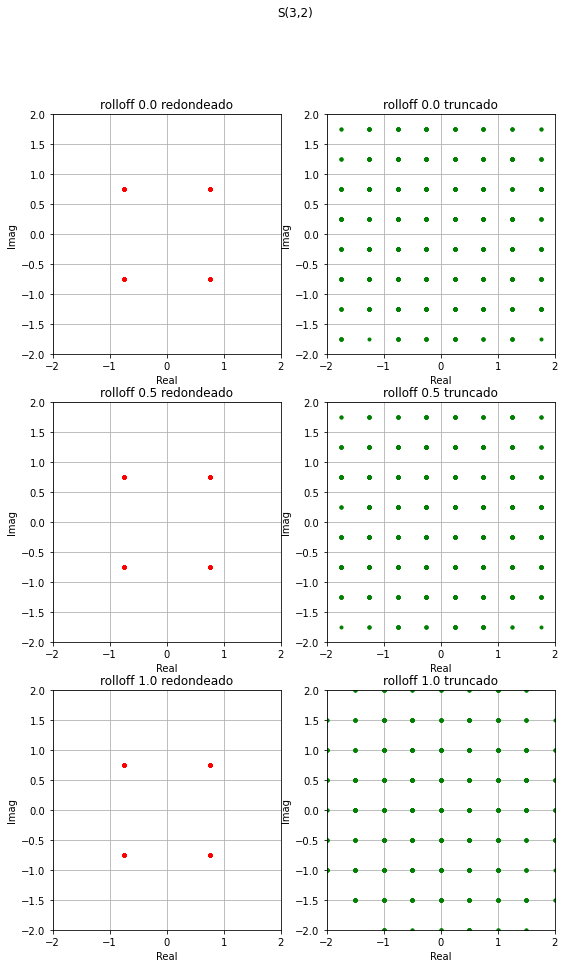

In [82]:
offset = 6



plt.figure(figsize=[3*3,3*5])
plt.subplot(3,2,1)
plt.plot(symb_out0I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 redondeado")
plt.subplot(3,2,2)
plt.plot(symb_out0I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 truncado")

#_______________________ rolloff  0.5 ___________________
plt.subplot(3,2,3)
plt.plot(symb_out1I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 redondeado")
plt.subplot(3,2,4)
plt.plot(symb_out1I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 truncado")

#_______________________ rolloff  1.0 ___________________
plt.subplot(3,2,5)
plt.plot(symb_out2I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out2Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 redondeado")
plt.subplot(3,2,6)
plt.plot(symb_out2I_t[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q_t[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 truncado")
plt.suptitle('S(3,2)') 
plt.show()


SNR:

In [83]:
#_______________________ rolloff  0.0 ___________________
pow_rc0_I=np.sum(symb_out0I**2)/len(symb_out0I)
pow_rc0_Q=np.sum(symb_out0Q**2)/len(symb_out0Q)

pow_rc0_I_r=np.sum(symb_out0I_r**2)/len(symb_out0I_r)
pow_rc0_Q_r=np.sum(symb_out0Q_r**2)/len(symb_out0Q_r)

pow_rc0_I_t=np.sum(symb_out0I_t**2)/len(symb_out0I_t)
pow_rc0_Q_t=np.sum(symb_out0Q_t**2)/len(symb_out0Q_t)

snr_rc0_I_r=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_r))
snr_rc0_Q_r=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_r))

snr_rc0_I_t=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_t))
snr_rc0_Q_t=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_t))
#_______________________ rolloff  0.5 ___________________
pow_rc1_I=np.sum(symb_out1I**2)/len(symb_out1I)
pow_rc1_Q=np.sum(symb_out1Q**2)/len(symb_out1Q)
pow_rc1_I_r=np.sum(symb_out1I_r**2)/len(symb_out1I_r)
pow_rc1_Q_r=np.sum(symb_out1Q_r**2)/len(symb_out1Q_r)
pow_rc1_I_t=np.sum(symb_out1I_t**2)/len(symb_out1I_t)
pow_rc1_Q_t=np.sum(symb_out1Q_t**2)/len(symb_out1Q_t)

snr_rc1_I_r=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_r))
snr_rc1_Q_r=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_r))

snr_rc1_I_t=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_t))
snr_rc1_Q_t=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_t))
#_______________________ rolloff  1.0 ___________________
pow_rc2_I=np.sum(symb_out2I**2)/len(symb_out2I)
pow_rc2_Q=np.sum(symb_out2Q**2)/len(symb_out2Q)
pow_rc2_I_r=np.sum(symb_out2I_r**2)/len(symb_out2I_r)
pow_rc2_Q_r=np.sum(symb_out2Q_r**2)/len(symb_out2Q_r)
pow_rc2_I_t=np.sum(symb_out2I_t**2)/len(symb_out2I_t)
pow_rc2_Q_t=np.sum(symb_out2Q_t**2)/len(symb_out2Q_t)

snr_rc2_I_r=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_r))
snr_rc2_Q_r=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_r))

snr_rc2_I_t=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_t))
snr_rc2_Q_t=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_t))

print("rolloff 0.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc0_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc0_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_t))+' dB')
print("rolloff 0.5 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc1_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc1_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_t))+' dB')
print("rolloff 1.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc2_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc2_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_t))+' dB')

rolloff 0.0 
  redondeo SNR_I: 17.32172800348154 dB  SNR_Q: 17.40822125252732 dB
  truncado SNR_I: 19.583857941377968 dB  SNR_Q: 22.73933972105359 dB
rolloff 0.5 
  redondeo SNR_I: 13.290683899006197 dB  SNR_Q: 13.59066738435825 dB
  truncado SNR_I: 17.760365868694745 dB  SNR_Q: 23.125037083207882 dB
rolloff 1.0 
  redondeo SNR_I: 15.045259532626279 dB  SNR_Q: 15.332641415211958 dB
  truncado SNR_I: 17.533916503720704 dB  SNR_Q: 16.248225326158895 dB


#### Cuantización S(6,4).

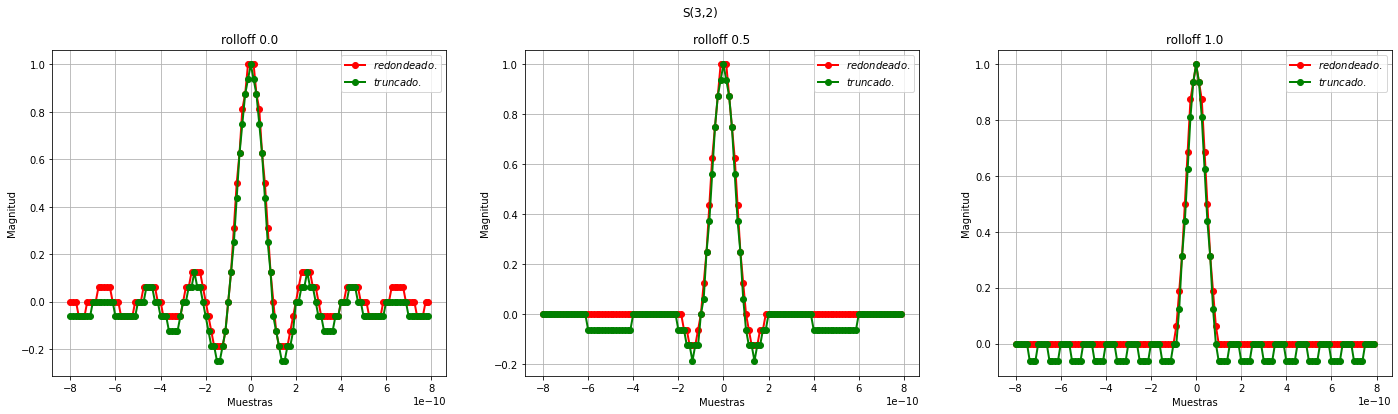

In [84]:
#_______________________ rolloff  0.0 ___________________
rc0_aux=arrayFixedInt(6, 4,rc0 , signedMode='S', roundMode='round', saturateMode='saturate')
rc0_sxx_r=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
rc0_aux=arrayFixedInt(6, 4,rc0 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc0_sxx_t=np.array([rc0_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  0.5 ___________________
rc1_aux=arrayFixedInt(6, 4,rc1 , signedMode='S', roundMode='round', saturateMode='saturate')
rc1_sxx_r=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
rc1_aux=arrayFixedInt(6, 4,rc1 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc1_sxx_t=np.array([rc1_aux[i].fValue for i in range(len(rc0_aux))])
#_______________________ rolloff  1.0 ___________________
rc2_aux=arrayFixedInt(6, 4,rc2 , signedMode='S', roundMode='round', saturateMode='saturate')
rc2_sxx_r=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])
rc2_aux=arrayFixedInt(6, 4,rc2 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc2_sxx_t=np.array([rc2_aux[i].fValue for i in range(len(rc0_aux))])

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(t,rc0_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc0_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.0")


plt.subplot(1,3,2)
plt.plot(t,rc1_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc1_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.5")


plt.subplot(1,3,3)
plt.plot(t,rc2_sxx_r,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.plot(t,rc2_sxx_t,'go-',linewidth=2.0,label=r'$truncado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 1.0")
plt.suptitle('S(3,2)') 
plt.show()

Respuesta en frecuencia.

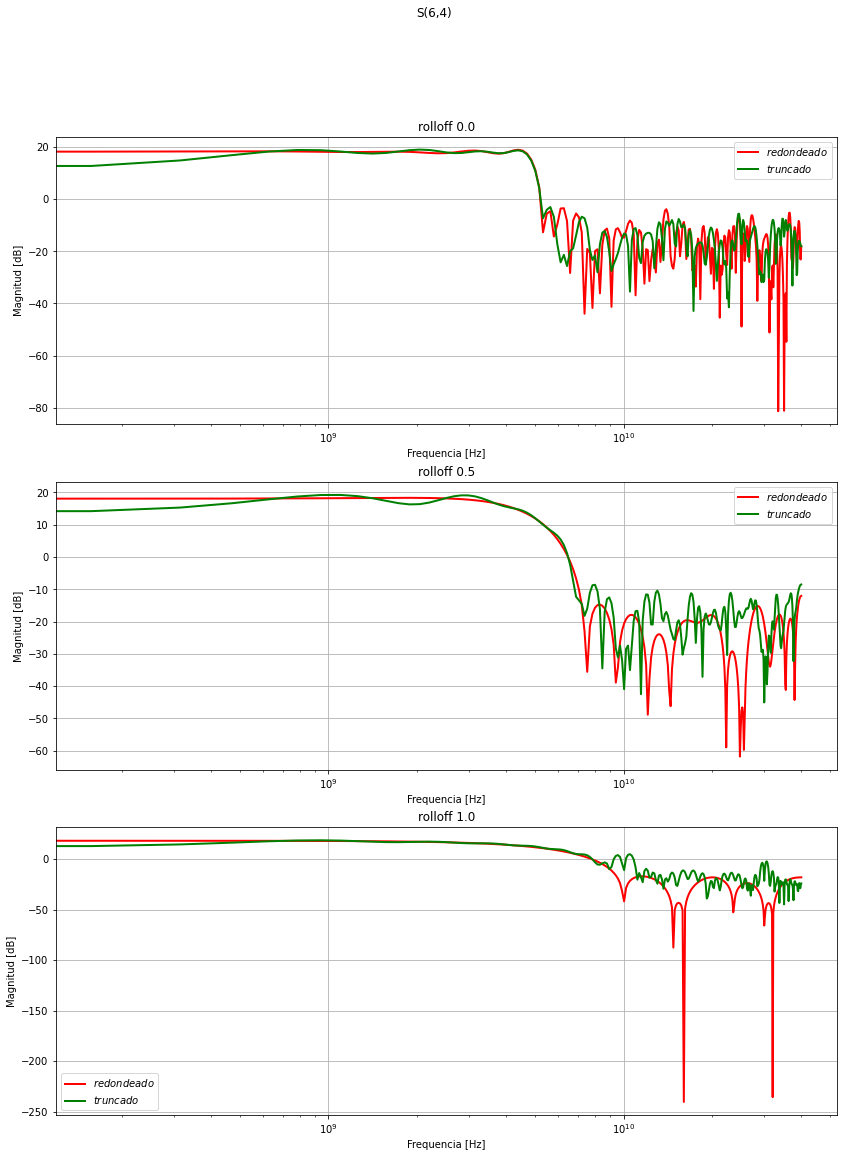

In [85]:
#_______________________ rolloff  0.0 ___________________
[H0_r,A0_r,F0_r] = resp_freq(rc0_sxx_r, Ts, Nfreqs)
[H0_t,A0_t,F0_t] = resp_freq(rc0_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.5 ___________________
[H1_r,A1_r,F1_r] = resp_freq(rc1_sxx_r, Ts, Nfreqs)
[H1_t,A1_t,F1_t] = resp_freq(rc1_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  1.0 ___________________
[H2_r,A2_r,F2_r] = resp_freq(rc2_sxx_r, Ts, Nfreqs)
[H2_t,A2_t,F2_t] = resp_freq(rc2_sxx_t, Ts, Nfreqs)
#_______________________ rolloff  0.0 ___________________
plt.figure(figsize=[14,6*3])
plt.subplot(3,1,1)
plt.semilogx(F0_r, 20*np.log10(H0_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F0_t, 20*np.log10(H0_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.0')
#_______________________ rolloff  0.5 ___________________
plt.subplot(3,1,2)
plt.semilogx(F1_r, 20*np.log10(H1_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F1_t, 20*np.log10(H1_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 0.5')
#_______________________ rolloff  1.0 ___________________
plt.subplot(3,1,3)
plt.semilogx(F2_r, 20*np.log10(H2_r),'r', linewidth=2.0, label=r'$redondeado$')
plt.semilogx(F2_t, 20*np.log10(H2_t),'g', linewidth=2.0, label=r'$truncado$')
plt.legend()
plt.grid(True)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('rolloff 1.0')
plt.suptitle('S(6,4)') 
plt.show()

Convolución.

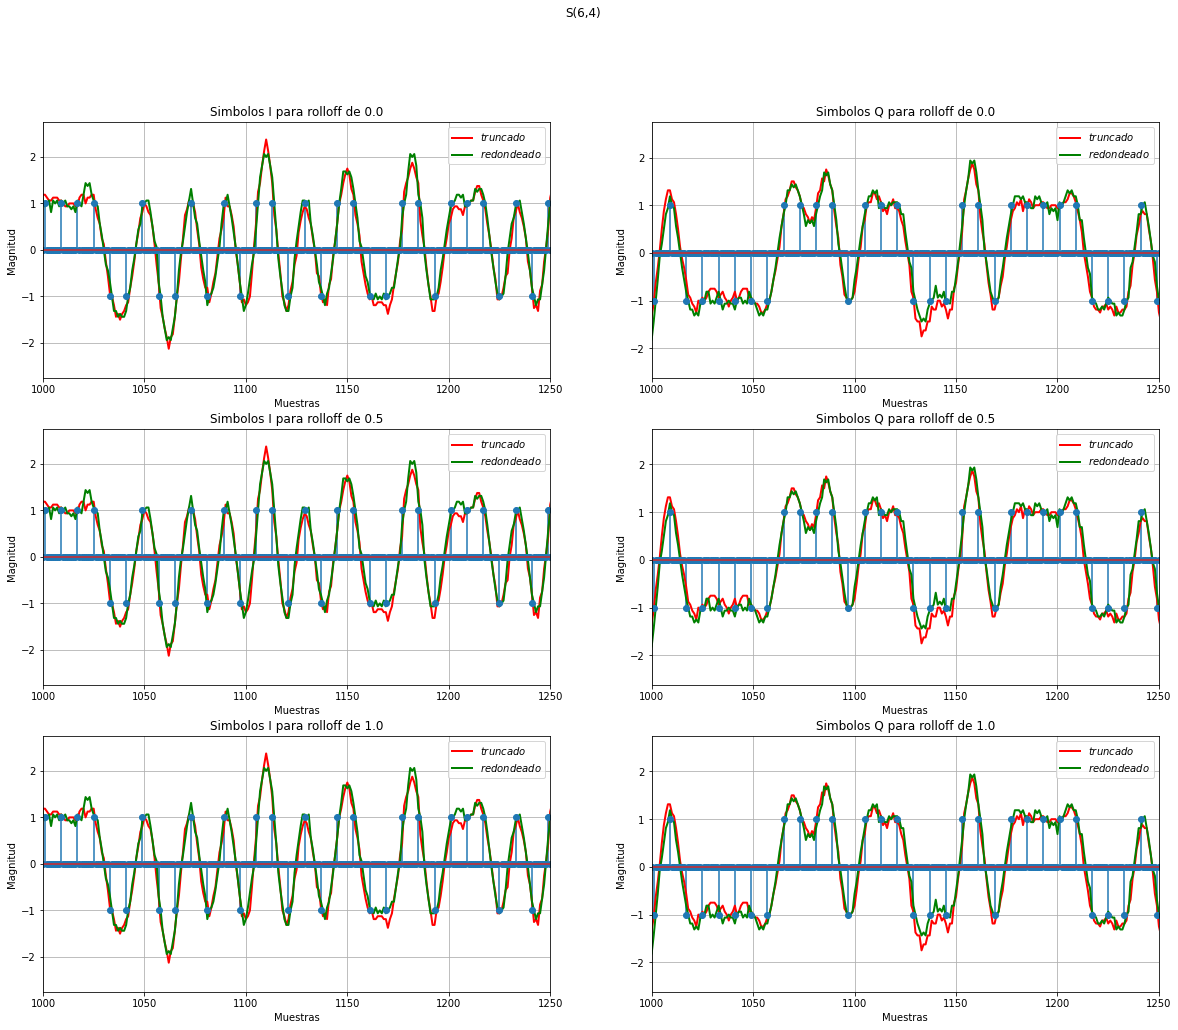

In [86]:
#_______________________ rolloff  0.0 ___________________
symb_out0I_r = np.convolve(rc0_sxx_r,zsymbI,'same')
symb_out0Q_r = np.convolve(rc0_sxx_r,zsymbQ,'same')
symb_out0I_t = np.convolve(rc0_sxx_t,zsymbI,'same')
symb_out0Q_t = np.convolve(rc0_sxx_t,zsymbQ,'same')
#_______________________ rolloff  0.5 ___________________
symb_out1I_r = np.convolve(rc1_sxx_r,zsymbI,'same')
symb_out1Q_r = np.convolve(rc1_sxx_r,zsymbQ,'same')
symb_out1I_t = np.convolve(rc1_sxx_t,zsymbI,'same')
symb_out1Q_t = np.convolve(rc1_sxx_t,zsymbQ,'same')
#_______________________ rolloff  1.0 ___________________
symb_out2I_r = np.convolve(rc2_sxx_r,zsymbI,'same')
symb_out2Q_r = np.convolve(rc2_sxx_r,zsymbQ,'same')
symb_out2I_t = np.convolve(rc2_sxx_t,zsymbI,'same')
symb_out2Q_t = np.convolve(rc2_sxx_t,zsymbQ,'same')

plt.figure(figsize=[10*2,4*4])
plt.subplot(3,2,1)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.0')
plt.subplot(3,2,2)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.0')


plt.subplot(3,2,3)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 0.5')
plt.subplot(3,2,4)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 0.5')


plt.subplot(3,2,5)
plt.plot(symb_out0I_t,'r-',linewidth=2.0,label=r'$truncado$')
plt.plot(symb_out0I_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos I para rolloff de 1.0')
plt.subplot(3,2,6)
plt.plot(symb_out0Q_t,'r-',linewidth=2.0,label=r'$truncado$' )
plt.plot(symb_out0Q_r,'g-',linewidth=2.0,label=r'$redondeado$')
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title('Simbolos Q para rolloff de 1.0')
plt.suptitle('S(6,4)') 

plt.show()

Constelación.

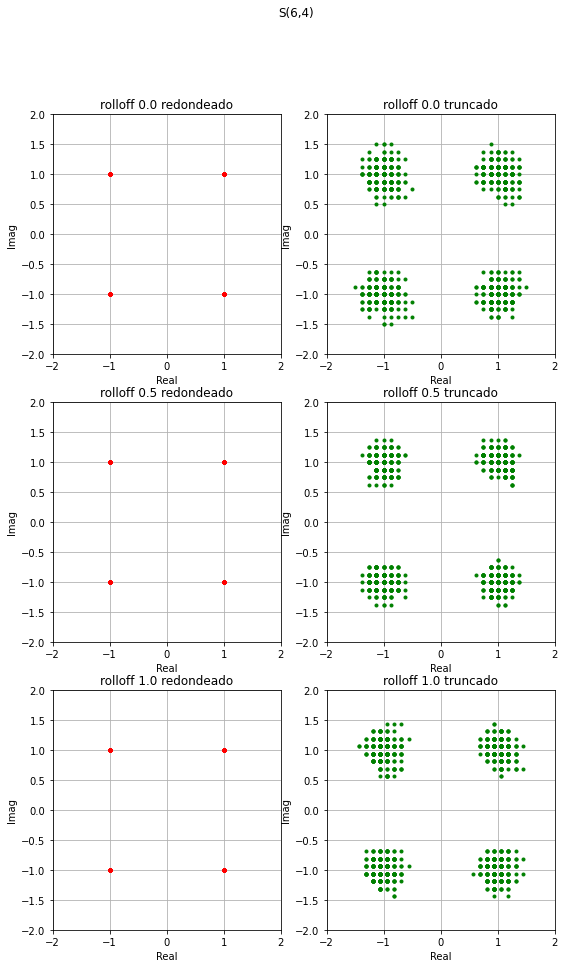

In [87]:
offset = 6
plt.figure(figsize=[3*3,3*5])
plt.subplot(3,2,1)
plt.plot(symb_out0I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 redondeado")
plt.subplot(3,2,2)
plt.plot(symb_out0I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.0 truncado")

#_______________________ rolloff  0.5 ___________________
plt.subplot(3,2,3)
plt.plot(symb_out1I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 redondeado")
plt.subplot(3,2,4)
plt.plot(symb_out1I_t[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out1Q_t[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5 truncado")

#_______________________ rolloff  1.0 ___________________
plt.subplot(3,2,5)
plt.plot(symb_out2I_r[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out2Q_r[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             'r.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 redondeado")
plt.subplot(3,2,6)
plt.plot(symb_out2I_t[100+offset:len(symb_out2I)-(100-offset):int(os)],
         symb_out2Q_t[100+offset:len(symb_out2Q)-(100-offset):int(os)],
             'g.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 1.0 truncado")
plt.suptitle('S(6,4)') 
plt.show()


SNR:

In [88]:
#_______________________ rolloff  0.0 ___________________
pow_rc0_I=np.sum(symb_out0I**2)/len(symb_out0I)
pow_rc0_Q=np.sum(symb_out0Q**2)/len(symb_out0Q)

pow_rc0_I_r=np.sum(symb_out0I_r**2)/len(symb_out0I_r)
pow_rc0_Q_r=np.sum(symb_out0Q_r**2)/len(symb_out0Q_r)

pow_rc0_I_t=np.sum(symb_out0I_t**2)/len(symb_out0I_t)
pow_rc0_Q_t=np.sum(symb_out0Q_t**2)/len(symb_out0Q_t)

snr_rc0_I_r=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_r))
snr_rc0_Q_r=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_r))

snr_rc0_I_t=abs(pow_rc0_I/(pow_rc0_I-pow_rc0_I_t))
snr_rc0_Q_t=abs(pow_rc0_Q/(pow_rc0_Q-pow_rc0_Q_t))
#_______________________ rolloff  0.5 ___________________
pow_rc1_I=np.sum(symb_out1I**2)/len(symb_out1I)
pow_rc1_Q=np.sum(symb_out1Q**2)/len(symb_out1Q)
pow_rc1_I_r=np.sum(symb_out1I_r**2)/len(symb_out1I_r)
pow_rc1_Q_r=np.sum(symb_out1Q_r**2)/len(symb_out1Q_r)
pow_rc1_I_t=np.sum(symb_out1I_t**2)/len(symb_out1I_t)
pow_rc1_Q_t=np.sum(symb_out1Q_t**2)/len(symb_out1Q_t)

snr_rc1_I_r=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_r))
snr_rc1_Q_r=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_r))

snr_rc1_I_t=abs(pow_rc1_I/(pow_rc1_I-pow_rc1_I_t))
snr_rc1_Q_t=abs(pow_rc1_Q/(pow_rc1_Q-pow_rc1_Q_t))
#_______________________ rolloff  1.0 ___________________
pow_rc2_I=np.sum(symb_out2I**2)/len(symb_out2I)
pow_rc2_Q=np.sum(symb_out2Q**2)/len(symb_out2Q)
pow_rc2_I_r=np.sum(symb_out2I_r**2)/len(symb_out2I_r)
pow_rc2_Q_r=np.sum(symb_out2Q_r**2)/len(symb_out2Q_r)
pow_rc2_I_t=np.sum(symb_out2I_t**2)/len(symb_out2I_t)
pow_rc2_Q_t=np.sum(symb_out2Q_t**2)/len(symb_out2Q_t)

snr_rc2_I_r=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_r))
snr_rc2_Q_r=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_r))

snr_rc2_I_t=abs(pow_rc2_I/(pow_rc2_I-pow_rc2_I_t))
snr_rc2_Q_t=abs(pow_rc2_Q/(pow_rc2_Q-pow_rc2_Q_t))

print("rolloff 0.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc0_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc0_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc0_Q_t))+' dB')
print("rolloff 0.5 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc1_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc1_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc1_Q_t))+' dB')
print("rolloff 1.0 ") 
print('  redondeo SNR_I: '+str(10*np.log(snr_rc2_I_r))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_r))+' dB')
print('  truncado SNR_I: '+str(10*np.log(snr_rc2_I_t))+' dB  SNR_Q: '+str(10*np.log(snr_rc2_Q_t))+' dB')

rolloff 0.0 
  redondeo SNR_I: 39.00840150871232 dB  SNR_Q: 38.45241803030688 dB
  truncado SNR_I: 38.34931822648525 dB  SNR_Q: 32.640380282508914 dB
rolloff 0.5 
  redondeo SNR_I: 44.78900194626328 dB  SNR_Q: 44.0171092394737 dB
  truncado SNR_I: 55.12351593676204 dB  SNR_Q: 36.72337793378836 dB
rolloff 1.0 
  redondeo SNR_I: 81.04543843352126 dB  SNR_Q: 55.43222802941166 dB
  truncado SNR_I: 34.78708283940136 dB  SNR_Q: 29.198181074812712 dB
